# Calculate RayTransfer Matrix (RTM) with PHiX Fast Camera

To show the RTM values and its behavior, we calculate a certain pixel's RTM.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from raysect.optical import World
from raysect.optical.observer import FullFrameSampler2D

from cherab.phix.machine import load_pfc_mesh
from cherab.phix.observer import load_camera
from cherab.phix.tools import profile_1D_to_2D
from cherab.phix.tools.raytransfer import load_rtc
from cherab.phix.tools.visualize import show_profiles
from cherab.tools.raytransfer import RayTransferPipeline2D

## Create scene world


In [2]:
# Generate scene world
world = World()

# Load phix machine configuration
mesh = load_pfc_mesh(world, reflection=True)

# Load phix raytrasfer cylinder object
rtc = load_rtc(world)

# Load phix camera
camera = load_camera(world)
camera.pixels = (128, 256)  # reduce resolution for faster rendering

✅ Vaccum Vessel         : RoughSUS316L (roughness: 0.0125)
✅ Vacuum Flange         : RoughSUS316L (roughness: 0.0125)
✅ Magnetron Port        : RoughSUS316L (roughness: 0.0125)
✅ Limiter Box           : RoughSUS316L (roughness: 0.2500)
✅ Limiter 225           : RoughSUS316L (roughness: 0.2500)
✅ Flux Loop             : RoughSUS316L (roughness: 0.2500)
✅ Feed Back Coil (upper): RoughSUS316L (roughness: 0.2500)
✅ Feed Back Coil (lower): RoughSUS316L (roughness: 0.2500)
✅ Rail (upper)          : RoughSUS316L (roughness: 0.2500)
✅ Rail (lower)          : RoughSUS316L (roughness: 0.2500)
✅ Rail Connection       : PCTFE
✅ Vacuum Vessel Gasket  : PCTFE
✅ Loading fast camera...


## Define Observer pipeline


In [3]:
rtp = RayTransferPipeline2D()

# set camera's pipeline property
camera.pipelines = [rtp]

## Set camera parameters

To focus one pixel, the `mask` array is defined.


In [4]:
focus_pixel = (50, 200)
mask = np.zeros(camera.pixels, dtype=bool)
mask[focus_pixel[0] - 1, focus_pixel[1] - 1] = True

Set the number of pixel and lens samples as $N_\text{pixel} = 10$, $N_\text{lens} = 10$


In [5]:
camera.frame_sampler = FullFrameSampler2D(mask=mask)
camera.min_wavelength = 655.6
camera.max_wavelength = 656.8
camera.spectral_rays = 1
camera.spectral_bins = rtc.bins
camera.per_pixel_samples = 10
camera.lens_samples = 10

## Execute ray-tracing

Note that a raytransfer matrix (RTM) is generated here and its shape is
$(N_\text{pixel, x}, N_\text{pixel, y}, \text{bins})$.
$\text{bins}$ means the number of light sources which corresponds to the number of pixels for
a tomographic reconstruction image. In this case, $\text{bins} = 13326$ which can be obtained by
`rtc.bins`.

Therefore the 2-D imaging RTM has 3 dimensions, and its size is so huge that it may cause memory
shortage.

In [6]:
camera.observe()

Render time: 3.041s (100.00% complete, 1.7k rays)
Render complete - time elapsed 3.043s - 0.6k rays/s


In [7]:
print(f"RTM size: {rtp.matrix.nbytes / 1024 ** 3:.2f} GB")

RTM size: 3.25 GB


## Visualize RayTransfer Matrix in $r - z$ plane


Convert RTM shape to $r-z$ poloidal 2D shape


In [8]:
rtm_profile = profile_1D_to_2D(rtp.matrix.sum(axis=0).sum(axis=0), rtc=rtc)

Set minimum value except for 0.0 to show the RTM profile logarithumically


In [9]:
vmin = rtm_profile[rtm_profile > 0].min() * 0.95

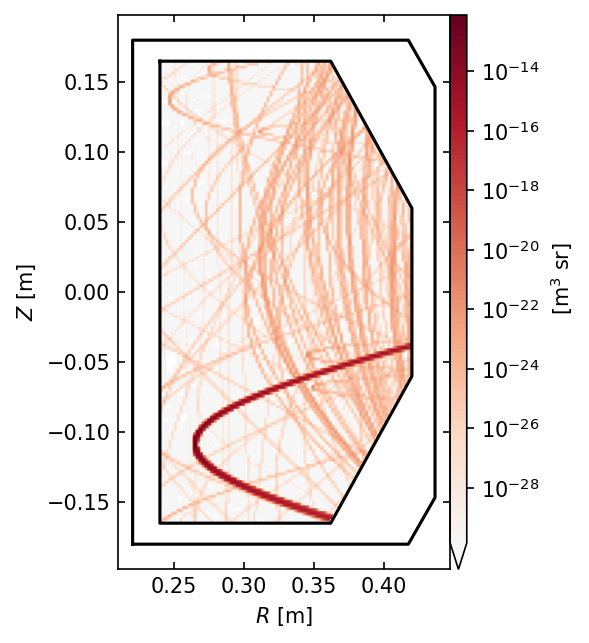

In [10]:
fig = plt.figure(dpi=150)
fig, axes = show_profiles(
    rtm_profile,
    fig=fig,
    rtc=rtc,
    clabel="[m$^3$ sr]",
    plot_mode="log",
    vmin=vmin,
)

We can figure out that the highest values correspond to the trajectory which rays triggered from a pixel pass through.


Let us check the RTM when reducing the number of samples as well.

Render time: 7.413s (100.00% complete, 0.0k rays)
Render complete - time elapsed 7.416s - 0.0k rays/s


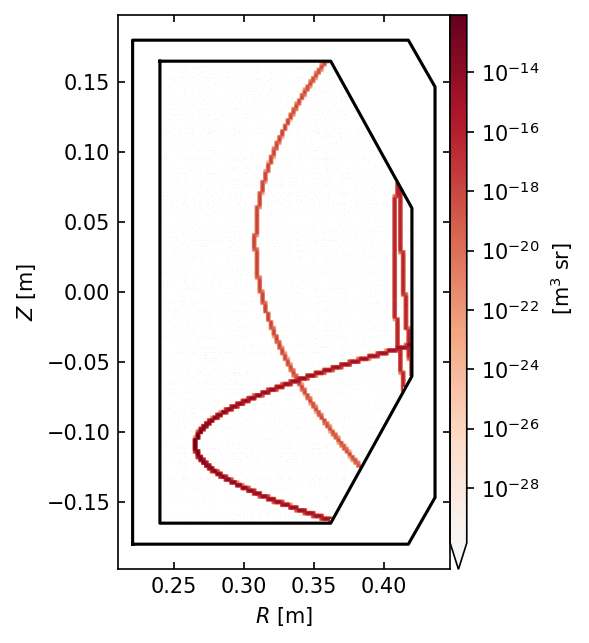

In [11]:
# redefine rtm pipeline
rtp2 = RayTransferPipeline2D()
camera.pipelines = [rtp2]

# reduce samples to 1
camera.per_pixel_samples = 1
camera.lens_samples = 1

# rendering
camera.observe()

# plot RTM
rtm_profile2 = profile_1D_to_2D(rtp2.matrix.sum(axis=0).sum(axis=0), rtc=rtc)
fig = plt.figure(dpi=150)
fig, axes = show_profiles(
    rtm_profile2,
    fig=fig,
    rtc=rtc,
    clabel="[m$^3$ sr]",
    plot_mode="log",
    vmin=vmin,
)